## Importing Modules

In [1]:
#pip install yfinance


In [2]:
import json
import pandas as pd
import numpy as np
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import yfinance as yahooFinance
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import *

## Data Preprocessing

### Raw Data From Yahoofinance

In [3]:
Ticker_Of_Firm='GAIL.NS'
Information = yahooFinance.Ticker(Ticker_Of_Firm)
Name_Of_Firm=Information.info['shortName']
df=Information.history(period='max')
df.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1997-04-02,5.561820,5.561820,5.561820,5.561820,799,0.0,0.0
1997-04-03,6.100978,6.100978,5.959094,6.044224,92799,0.0,0.0
1997-04-04,6.356366,6.450009,6.248535,6.444334,264799,0.0,0.0
1997-04-07,6.450011,6.450011,6.257049,6.288264,131999,0.0,0.0
1997-04-08,6.288264,6.288264,6.288264,6.288264,0,0.0,0.0
1997-04-09,6.867147,6.915388,6.810394,6.915388,365599,0.0,0.0
1997-04-10,6.867147,7.363739,6.586219,6.906875,331199,0.0,0.0
1997-04-11,6.753638,7.037405,6.668509,6.764989,188799,0.0,0.0
1997-04-14,6.764989,6.764989,6.764989,6.764989,0,0.0,0.0


### Graphs


Text(0, 0.5, 'Price Of Stock (INR) ')

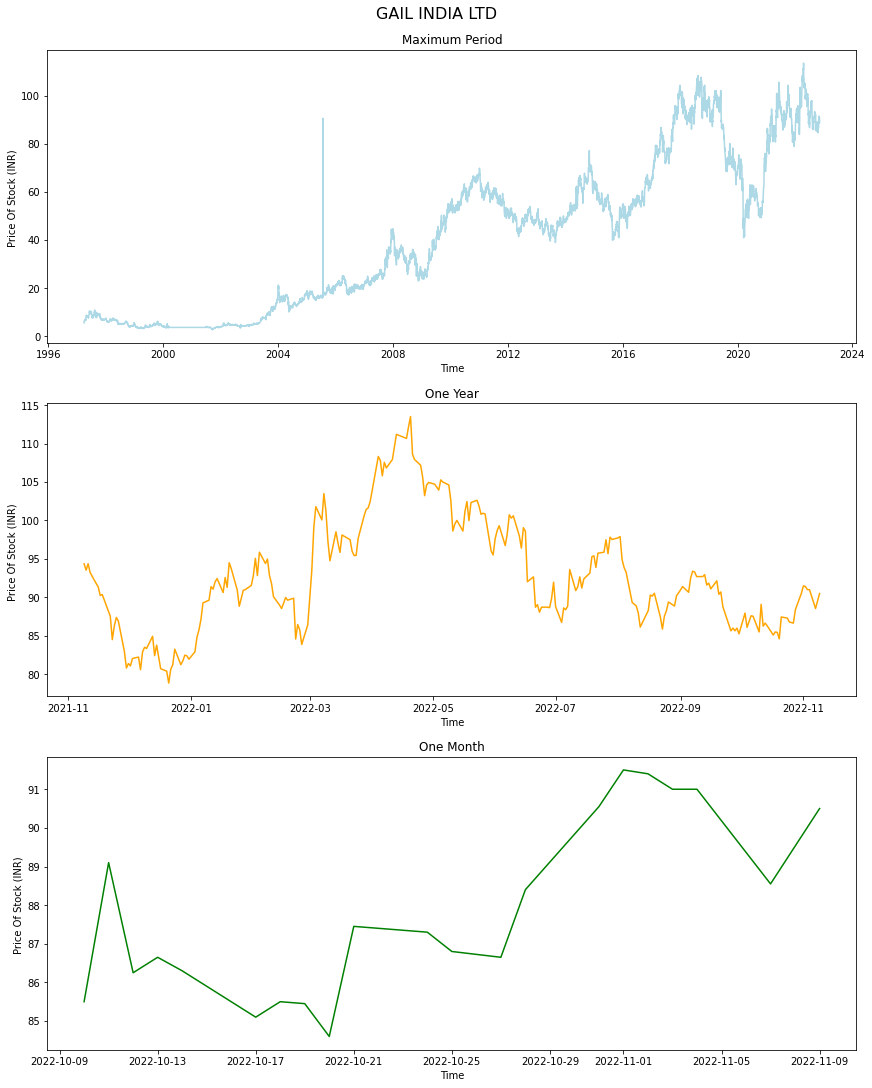

In [4]:
fig, axs = plt.subplots(3, 1, constrained_layout=True,figsize=(12,15))
fig.suptitle(Name_Of_Firm, fontsize=16)


# for Full Data Available
axs[0].plot(Information.history(period='max')[['Open']],color='lightblue')
axs[0].set_title('Maximum Period')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Price Of Stock (INR) ')

# for One Year
axs[1].plot(Information.history(period='1y')[['Open']],color='orange')
axs[1].set_xlabel('Time')
axs[1].set_title('One Year')
axs[1].set_ylabel('Price Of Stock (INR) ')

# for One Month 
axs[2].plot(Information.history('1mo')[['Open']],color='green')
axs[2].set_xlabel('Time')
axs[2].set_title('One Month')
axs[2].set_ylabel('Price Of Stock (INR) ')
#plt.show()

### Understanding Of Data

The size of data set is: 5000
The size of training data set is: 4900
The size of validation data set is: 100


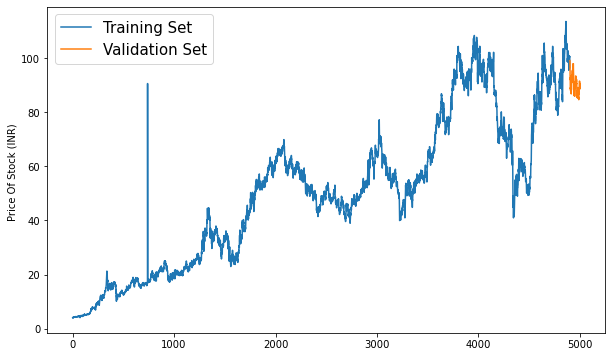

In [5]:
#Data
Data=Information.history(period='max')[['Open']]
Data=np.array(Data)[-5000:]

scaler=MinMaxScaler(feature_range=(0, 1))
scaler=scaler.fit(Data)
Data_Normalised=scaler.transform(Data).flatten()
Data=Data.flatten()
Data_size=Data.size
Validation_size=100
Time=np.arange(1,Data_size+1)
print(f'The size of data set is: {Data_size}')
print(f'The size of training data set is: {Data_size-Validation_size}')
print(f'The size of validation data set is: {Validation_size}')
Data_Dictionary={
'Series':Data[:]  ,  
'Data_Training':Data[:Data_size-Validation_size],
'Data_Validation':Data[Data_size-Validation_size:],
'Time_Training':Time[:Data_size-Validation_size],
'Time_Validation':Time[Data_size-Validation_size:]
}
    
Data_Normalised_Dictionary={
'Series':Data_Normalised[:]  ,  
'Data_Training':Data_Normalised[:Data_size-Validation_size],
'Data_Validation':Data_Normalised[Data_size-Validation_size:],
'Time_Training':Time[:Data_size-Validation_size],
'Time_Validation':Time[Data_size-Validation_size:]
}    
Data_Normalised_Dictionary=Data_Dictionary    
#Figure
fig=plt.figure(figsize=(10,6))
plt.plot(Data_Dictionary['Time_Training'],Data_Dictionary['Data_Training'])
plt.plot(Data_Dictionary['Time_Validation'],Data_Dictionary['Data_Validation'])
plt.ylabel('Price Of Stock (INR) ')
plt.legend(['Training Set','Validation Set'],fontsize=15)
plt.show()

### Setting Of Data and Initial Parameters

In [6]:
window_size=60
batch_size=200

# function for windowing of data set and making of batches
def windowed_dataset(data,shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))        
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset


## Model Architecture

In [13]:
#setting random seed for numpy and tensorflow
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


# Halt Calss , Function call after every epoch
Loss_List=[]
class haltCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        loss_value=1
        Loss_List.append(logs.get('loss'))
        if(logs.get('loss') <= loss_value):
            print(f"\n\n\nReached {loss_value} loss value so cancelling training!\n\n\n")
            self.model.stop_training = True

trainingStopCallback=haltCallback()        
            
# model
model = tf.keras.models.Sequential([
          tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),  # Lambda layer for expanding dimention
          tf.keras.layers.SimpleRNN(40,return_sequences=True),
          tf.keras.layers.SimpleRNN(40,return_sequences=False),
          #tf.keras.layers.LSTM(45,activation ='tanh'),
          tf.keras.layers.Dense(1),
          tf.keras.layers.Lambda(lambda x: x * 100.0)
        ])






# Optimization and Loss

initial_learning_rate = 4e-8
decay_steps = 207*1.2
decay_rate = 0.5
no_of_epoch=70
no_of_batch=Data_size//batch_size
learning_rate_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
                          initial_learning_rate=initial_learning_rate,
                          decay_steps=decay_steps,
                          decay_rate=decay_rate)



optimizer = tf.keras.optimizers.SGD(learning_rate_schedule,momentum=0.9)     #SGD was old optimizer, momentum was 0.9
model.compile(loss=tf.keras.losses.MeanSquaredError() ,                      # earlier it was Huber()
                      optimizer=optimizer,
                      metrics=["mae"])
# Take a look at our Model
print(model.summary())
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 40)          1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________
None
You must install pydot (`pip install pydot`) and 

## Decay In Learning Rate

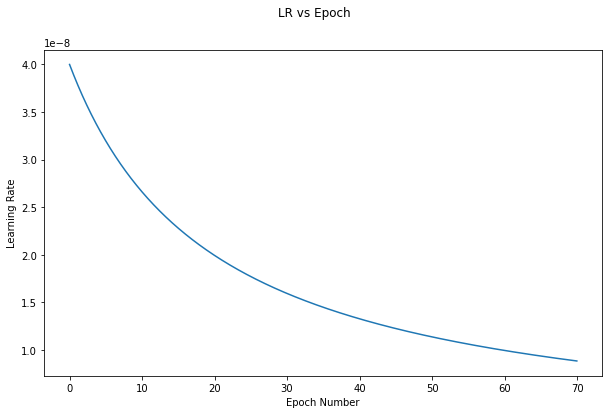

In [14]:
step = np.arange(0,no_of_epoch*no_of_batch)
lr = learning_rate_schedule(step)
fig=plt.figure(figsize=(10, 6))
fig.suptitle('LR vs Epoch')
plt.plot(step/no_of_batch,lr)
plt.ylabel('Learning Rate')
_=plt.xlabel('Epoch Number')

### Fitting and Forecasting

In [15]:
tf.keras.backend.clear_session()
#tf.random.set_seed(27)
#np.random.seed(27)

dataset=windowed_dataset(Data_Normalised_Dictionary['Data_Training'])
history = model.fit(dataset,epochs=no_of_epoch,callbacks=[trainingStopCallback])

Epoch 1/70
25/25 [==============================] - 2s 21ms/step - loss: 430.9986 - mae: 16.8554
Epoch 2/70
25/25 [==============================] - 1s 21ms/step - loss: 81.7949 - mae: 7.2779
Epoch 3/70
25/25 [==============================] - 1s 21ms/step - loss: 27.6671 - mae: 4.0571
Epoch 4/70
25/25 [==============================] - 1s 21ms/step - loss: 22.1083 - mae: 3.6073
Epoch 5/70
25/25 [==============================] - 1s 22ms/step - loss: 17.7091 - mae: 3.2544
Epoch 6/70
25/25 [==============================] - 1s 20ms/step - loss: 16.5733 - mae: 3.1815
Epoch 7/70
25/25 [==============================] - 1s 20ms/step - loss: 14.0525 - mae: 2.8979
Epoch 8/70
25/25 [==============================] - 1s 20ms/step - loss: 13.0031 - mae: 2.7448
Epoch 9/70
25/25 [==============================] - 1s 20ms/step - loss: 12.2365 - mae: 2.6884
Epoch 10/70
25/25 [==============================] - 1s 20ms/step - loss: 11.4745 - mae: 2.5649
Epoch 11/70
25/25 [============================

In [16]:
#forecasting
Data_for_prediction=Data_Normalised_Dictionary['Series'][-window_size-Validation_size:]
dataset=windowed_dataset(Data_for_prediction,1)
result_forecast=model.predict(dataset).flatten()    
#forecast=scaler.inverse_transform(forecast.reshape((-1,1))).flatten() 

    


1/1 [==============================] - 0s 230ms/step


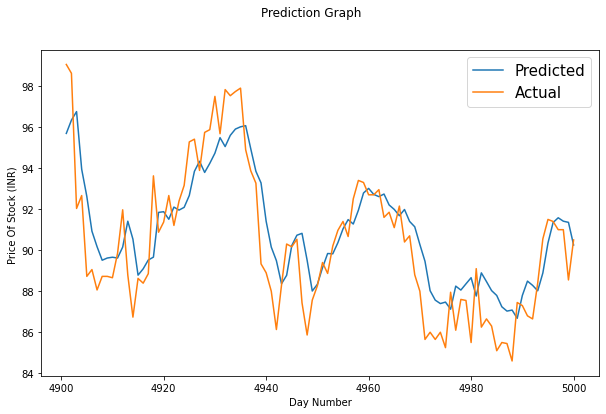

In [17]:
#figure
fig=plt.figure(figsize=(10, 6))
fig.suptitle('Prediction Graph')
plt.plot(Data_Dictionary['Time_Validation'],result_forecast)
plt.plot(Data_Dictionary['Time_Validation'],Data_Dictionary['Data_Validation'])
plt.ylabel('Price Of Stock (INR) ')
plt.xlabel('Day Number')

plt.legend(['Predicted','Actual'],fontsize=15)
plt.show()

## Analysis

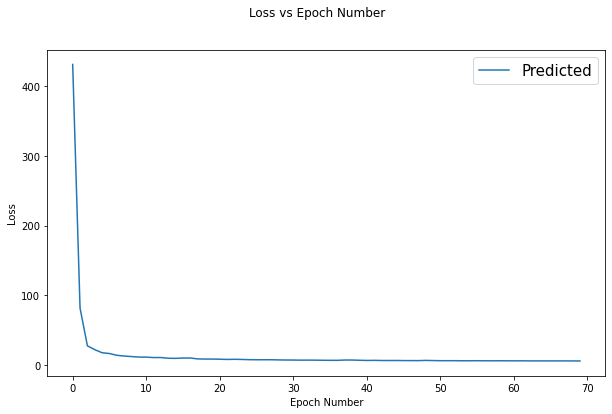

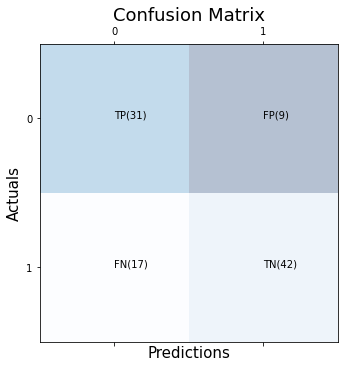

In [18]:
#figure
fig=plt.figure(figsize=(10, 6))
fig.suptitle('Loss vs Epoch Number')
plt.plot(Loss_List)
plt.ylabel('Loss')
plt.xlabel('Epoch Number')

plt.legend(['Predicted','Actual'],fontsize=15)
plt.show()
inc_dec_actual=Data_Dictionary['Data_Validation'][1:]-Data_Dictionary['Data_Validation'][:-1]>0
inc_dec_actual=inc_dec_actual.astype('int')
inc_dec_predictaed=Data_Dictionary['Data_Validation'][1:]-result_forecast[:-1]>0
inc_dec_predictaed=inc_dec_predictaed.astype('int')
TP = np.count_nonzero(inc_dec_predictaed * inc_dec_actual)
TN = np.count_nonzero((inc_dec_predictaed - 1) * (inc_dec_actual - 1))
FP = np.count_nonzero(inc_dec_predictaed * (inc_dec_actual - 1))
FN = np.count_nonzero((inc_dec_predictaed - 1) * inc_dec_actual)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
accurcy=(TP+TN)/(TP+TN+FP+FN)
fig, axs = plt.subplots(1, 1, constrained_layout=True,figsize=(5,5))
plt.title('Confusion Matrix', fontsize=18)

axs.matshow([[TP,TN],[FP,FN]],cmap=plt.cm.Blues, alpha=0.3)
axs.ticklabel_format()
plt.xlabel('Predictions', fontsize=15)
axs.text(1,1,f'TN({TN})')
axs.text(1,0,f'FP({FP})')
axs.text(0,0,f'TP({TP})')
axs.text(0,1,f'FN({FN})')
plt.ylabel('Actuals', fontsize=15)
plt.show()